In [1]:
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from scipy.optimize import linear_sum_assignment

from utils import get_anndata

In [2]:
results_dir = Path("./results")

dlpfc_results_dir = results_dir / "LIBD_DLPFC"
data_dir = Path("./data/LIBD_DLPFC")

spatial_embedding_results_dir = results_dir / "spatial_embedding"

metadata_file = "downloads.tsv"
sdm_dir = Path("./data/sdmbench")

fig_dir = results_dir / "figures"

In [3]:
fig_dir.mkdir(parents=True, exist_ok=True)

In [4]:
mm = 0.1 / 2.54
dpi = 600

In [5]:
rename_methods = {
    "leiden": "Leiden\nHVG PCA",
    "spatial_leiden": "SpatialLeiden\nHVG PCA",
    "leiden_svg": "Leiden\nSVG PCA",
    "spatial_leiden_svg": "SpatialLeiden\nSVG PCA",
    "leiden_svg_multispati": "Leiden\nSVG msPCA",
    "spatial_leiden_svg_multispati": "SpatialLeiden\nSVG msPCA",
}

In [6]:
scale_factors = {
    "151676": 96.38356730700866,
    "151675": 96.39297012575229,
    "151674": 96.3779209567421,
    "151673": 96.40082438014726,
    "151672": 96.366076971651,
    "151671": 96.38644715313141,
    "151670": 96.36089958505312,
    "151669": 96.37890036828857,
    "151510": 96.8900012037373,
    "151509": 97.24346019692305,
    "151508": 96.36956627416598,
    "151507": 96.37511184430237,
}

In [7]:
def remove_tick_and_label(ax):
    ax.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel=None)
    ax.tick_params(left=False, bottom=False)


def scatter_labels(df, name, ax, title="top"):
    _ = sns.scatterplot(df, x="x", y="y", hue=name, ax=ax, **scatter_kwargs)
    ax.set(aspect=1, xlim=(0, df["x"].max()), ylim=(df["y"].max(), 0))
    ax.legend([], [], frameon=False)
    remove_tick_and_label(ax)
    if title == "top":
        ax.set_title(name)
    elif title == "left":
        ax.set_ylabel(name)

# Patient Plots

In [8]:
groundtruth = pd.DataFrame(
    [(f.parent.name, f) for f in data_dir.glob("*/labels.tsv")],
    columns=["sample", "groundtruth"],
).set_index("sample")

image_files = pd.DataFrame(
    [(f.parent.name, f) for f in data_dir.glob("*/H_E.tiff")],
    columns=["sample", "image"],
).set_index("sample")

coordinate_files = pd.DataFrame(
    [(f.parent.name, f) for f in data_dir.glob("*/coordinates.tsv")],
    columns=["sample", "coordinates"],
).set_index("sample")

results = {
    f.name: {tsv.stem: tsv for tsv in f.glob("*.tsv")}
    for f in dlpfc_results_dir.glob("Br*")
}

files = (
    pd.DataFrame(results)
    .transpose()
    .merge(groundtruth, left_index=True, right_index=True)
    .merge(image_files, left_index=True, right_index=True)
    .merge(coordinate_files, left_index=True, right_index=True)
    .rename(columns=rename_methods)
)

files.index = files.index.str.split("_", expand=True).set_names(["patient", "sample"])

In [9]:
import matplotlib as mpl

mpl.rcParams.update({"axes.titlesize": 6})
mpl.rcParams.update({"axes.labelsize": 6})

scatter_kwargs = {"s": 0.8, "marker": "h", "linewidth": 0}

In [10]:
# disable DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None


def plot_patient(metadata, patient):
    metadata = metadata.loc[patient, :].sort_index()

    fig, axs = plt.subplots(
        nrows=10, ncols=4, sharex="col", sharey="col", figsize=(85 * mm, 200 * mm)
    )

    for i, (sample, files) in enumerate(metadata.iterrows()):
        px_per_um = scale_factors[sample] / 65
        image = np.array(Image.open(files.pop("image")))
        data = pd.read_table(files.pop("coordinates"), index_col=0)

        for name, file in files.items():
            labels_df = pd.read_table(file, index_col=0)
            labels_df.columns = [name]
            labels_df[name] = labels_df[name].astype("category")

            data = data.merge(labels_df, left_index=True, right_index=True)

        x_crop = (data["x"].min(), data["x"].max())
        y_crop = (data["y"].min(), data["y"].max())

        image = image[slice(*y_crop), slice(*x_crop)]
        data = data.assign(
            x=lambda df: df["x"] - x_crop[0], y=lambda df: df["y"] - y_crop[0]
        )

        _ = axs[0, i].imshow(image)
        axs[0, i].set(title=sample)
        remove_tick_and_label(axs[0, i])
        scale_bar = AnchoredSizeBar(
            axs[0, i].transData,
            px_per_um * 1_000,
            r"1 mm",
            loc="lower right",
            frameon=False,
            fontproperties={"size": 5},
        )
        axs[0, i].add_artist(scale_bar)
        if i == 0:
            axs[0, i].set_ylabel("H & E")
            title = "left"
        else:
            title = None

        scatter_labels(data, "groundtruth", axs[1, i], title)
        scatter_labels(data, "Leiden\nHVG PCA", axs[2, i], title)
        scatter_labels(data, "Leiden\nSVG PCA", axs[3, i], title)
        scatter_labels(data, "Leiden\nSVG msPCA", axs[4, i], title)
        scatter_labels(data, "SpatialLeiden\nHVG PCA", axs[5, i], title)
        scatter_labels(data, "SpatialLeiden\nSVG PCA", axs[6, i], title)
        scatter_labels(data, "SpatialLeiden\nSVG msPCA", axs[7, i], title)
        scatter_labels(data, "SpaGCN", axs[8, i], title)
        scatter_labels(data, "BayesSpace", axs[9, i], title)

    fig.tight_layout(h_pad=0.5, w_pad=0.5)

    return fig

## Supplementary Figure 1 (Br5292)

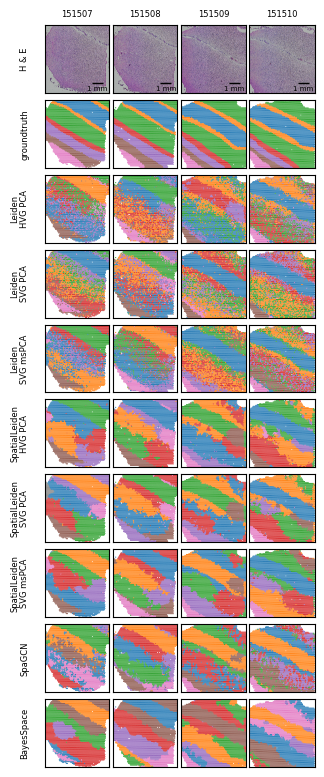

In [11]:
SFig1 = plot_patient(files, "Br5292")
SFig1.savefig(fig_dir / "FigS1.png", dpi=dpi)

## Supplementary Figure 2 (Br5595)

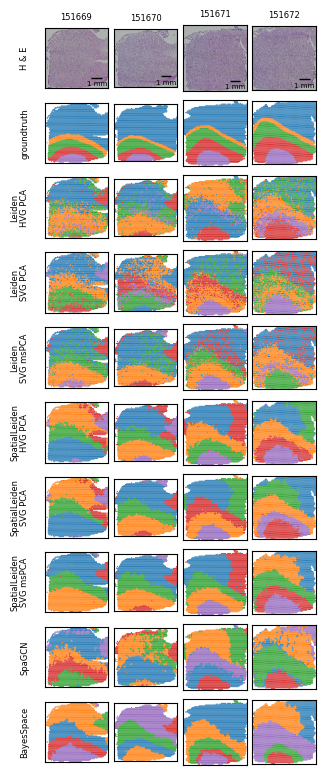

In [12]:
SFig2 = plot_patient(files, "Br5595")
SFig2.savefig(fig_dir / "FigS2.png", dpi=dpi)

## Supplementary Figure 3 (Br8100)

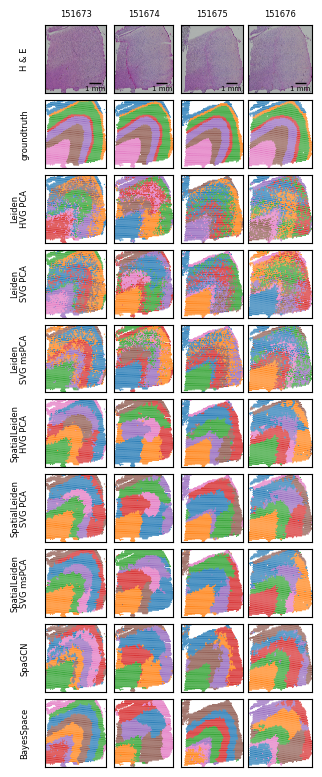

In [13]:
SFig3 = plot_patient(files, "Br8100")
SFig3.savefig(fig_dir / "FigS3.png", dpi=dpi)

# Supplementary Figure 4: Layer ratio

In [14]:
def format_weight(f):
    if float(f).is_integer():
        return str(int(float(f)))
    return f

In [15]:
rename_methods["leiden"] = "Leiden HVG PCA"
rename_methods["spatial_leiden"] = "SpatialLeiden HVG PCA"

In [16]:
sample = "Br8100_151673"


files = pd.DataFrame(
    [(f.stem, f) for f in dlpfc_results_dir.glob(f"weightratio_impact/{sample}/*.tsv")],
    columns=["method", "file"],
).assign(weight=lambda df: df["method"].str.extract("_w([0-9.]+)"))

files[["method", None]] = files["method"].str.split("_w", expand=True)

files = files.assign(method=lambda df: df["method"].replace(rename_methods))

files.loc[lambda df: df["method"] == "SpatialLeiden HVG PCA", "method"] = (
    files.loc[lambda df: df["method"] == "SpatialLeiden HVG PCA", "method"]
    + " (1:"
    + files.loc[lambda df: df["method"] == "SpatialLeiden HVG PCA", "weight"].map(
        format_weight
    )
    + ")"
)

files = (
    files.set_index("method")
    .astype({"weight": float})
    .sort_values("weight", na_position="first")["file"]
)

In [17]:
data = pd.read_table(data_dir / sample / "coordinates.tsv", index_col=0)
data -= data.min(axis=0)

for i, (name, file) in enumerate(files.items()):
    labels_df = pd.read_table(file, index_col=0, dtype="category")
    labels_df.columns = [name]
    data = data.merge(labels_df, left_index=True, right_index=True)

# match clusters
for i in range(2, data.shape[1] - 1):
    contingency_table = pd.crosstab(data.iloc[:, i + 1], data.iloc[:, i])
    row_ind, col_ind = linear_sum_assignment(contingency_table, maximize=True)
    data.iloc[:, i + 1] = data.iloc[:, i + 1].cat.rename_categories(
        dict(zip(contingency_table.index[row_ind], contingency_table.columns[col_ind]))
    )

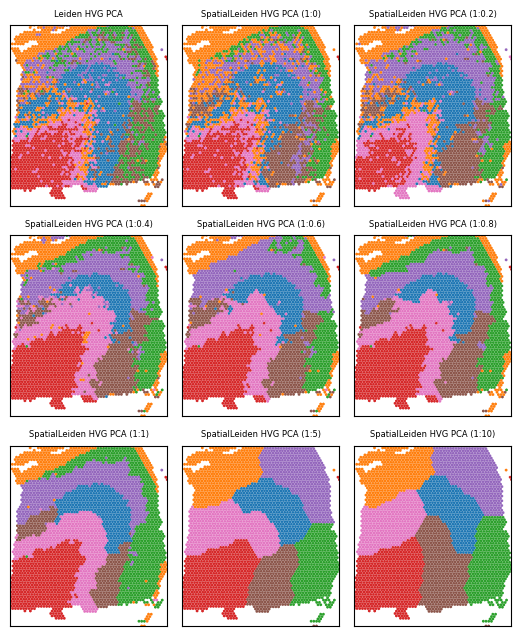

In [18]:
scatter_kwargs = {"s": 5, "marker": "h", "linewidth": 0}


fig, axs = plt.subplots(
    nrows=3, ncols=3, sharex=True, sharey=True, figsize=(135 * mm, 165 * mm)
)

for i, name in enumerate(data.columns[2:]):
    scatter_labels(data, name, axs[i // 3, i % 3])

fig.tight_layout()
fig.savefig(fig_dir / "FigS4.png", dpi=dpi)

# Spatial Embedding effects

In [19]:
metadata = pd.read_table(metadata_file, index_col=0)

metadata = metadata.assign(path=lambda df: sdm_dir / df["url"].str.split("/").str[-1])

In [20]:
def plot_spatial_embedding_effect(df, col_order, row_order, coords, aspect=1):
    n_row = len(row_order)
    n_col = len(col_order)
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        sharex=True,
        sharey=True,
        figsize=(170 * mm, 170 * mm / aspect / (n_col / n_row)),
    )

    coords -= coords.min()

    for i, row_id in enumerate(row_order):
        for j, col_id in enumerate(col_order):
            labels_df = (
                pd.read_table(df.at[row_id, col_id], index_col=0)
                .astype("category")
                .join(coords)
            )

            scatter_labels(labels_df, "label", axs[i, j], None)

            if j == 0:
                axs[i, j].set_ylabel(row_id)
            if i == 0:
                axs[i, j].set_title(col_id)

    fig.tight_layout()

    return fig

## Supplementary Figure 5

In [21]:
sample = "MERFISH_0.14"

In [22]:
files = pd.DataFrame(
    [(f.stem, f) for f in (spatial_embedding_results_dir / sample).glob("*.tsv")],
    columns=["method", "file"],
).assign(
    weight=lambda df: "Layer ratio 1:" + df["method"].str.extract("_w([0-9.]+)"),
    neighbors=lambda df: df["method"].str.extract("neighbors_([^_]+)_"),
)

files["neighbors"] = np.where(
    files["neighbors"] != "delaunay", "kNN" + files["neighbors"], files["neighbors"]
)

files = files.pivot(index="neighbors", columns="weight", values="file")

In [23]:
row_order = ["delaunay", "kNN5", "kNN10", "kNN15", "kNN20", "kNN50"]
col_order = [
    "Layer ratio 1:0.5",
    "Layer ratio 1:1.0",
    "Layer ratio 1:1.5",
    "Layer ratio 1:2.0",
    "Layer ratio 1:4.0",
]

In [24]:
adata = ad.read_h5ad(metadata.at[sample, "path"])

coords = pd.DataFrame(adata.obsm["spatial"], columns=["x", "y"], index=adata.obs_names)

del adata

In [25]:
scatter_kwargs = {"s": 1, "linewidth": 0}

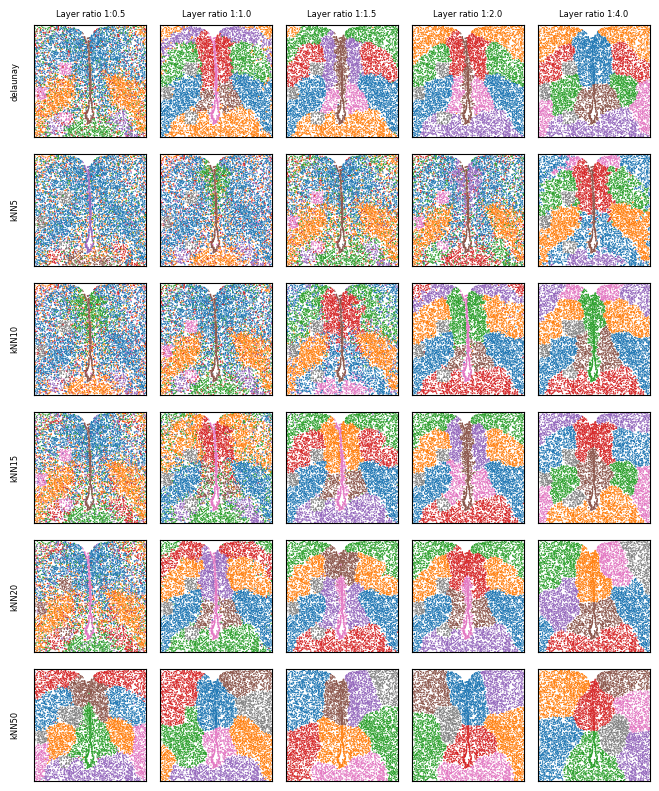

In [26]:
SFig5 = plot_spatial_embedding_effect(files, col_order, row_order, coords)
SFig5.savefig(fig_dir / "FigS5.png", dpi=dpi)

## Supplementary Figure 6

In [27]:
sample = "E10.5_E1S2.MOSTA"

In [28]:
files = pd.DataFrame(
    [(f.stem, f) for f in (spatial_embedding_results_dir / sample).glob("*.tsv")],
    columns=["method", "file"],
).assign(
    weight=lambda df: "Layer ratio 1:" + df["method"].str.extract("_w([0-9.]+)"),
    neighbors=lambda df: df["method"].str.extract("neighbors_([^_]+)_"),
)

files = files.pivot(index="neighbors", columns="weight", values="file").rename(
    columns={"Layer ratio 1:0.2": "Layer ratio 1:0.25"}
)

In [29]:
row_order = ["1x4", "1x8", "2x4", "2x8"]
col_order = [
    "Layer ratio 1:0.25",
    "Layer ratio 1:0.5",
    "Layer ratio 1:1.0",
    "Layer ratio 1:1.5",
    "Layer ratio 1:2.0",
]

In [30]:
adata = ad.read_h5ad(metadata.at[sample, "path"])

coords = pd.DataFrame(adata.obsm["spatial"], columns=["x", "y"], index=adata.obs_names)

del adata

In [31]:
scatter_kwargs = {"s": 0.4, "linewidth": 0, "marker": "s"}

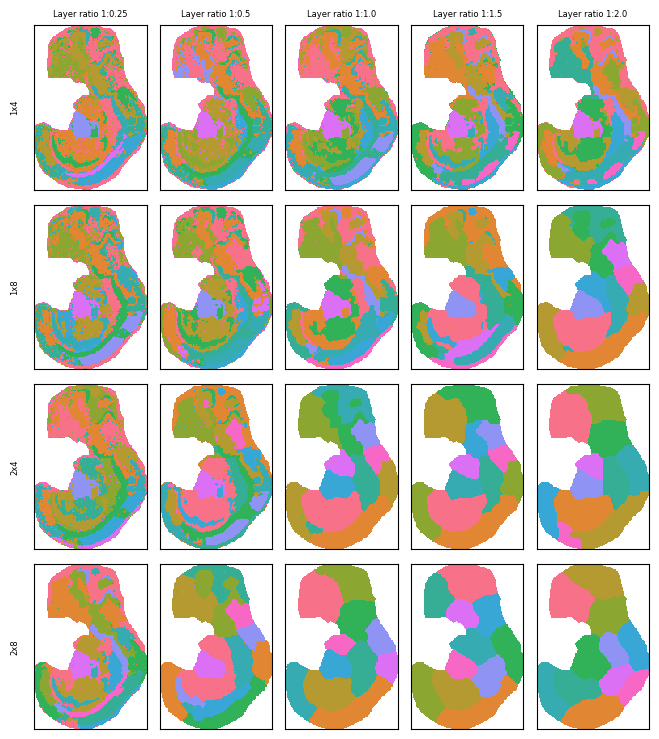

In [32]:
SFig6 = plot_spatial_embedding_effect(
    files, col_order, row_order, coords, aspect=2.5 / 3.5
)
# for ax in SFig6.axes:
#     if (l := ax.get_ylabel()) != "":
#         ax.set_ylabel(l, labelpad=50)
# fig.tight_layout()
SFig6.savefig(fig_dir / "FigS6.png", dpi=dpi)

# Supplementary Figure 7: X + SpatialLeiden

In [33]:
sample = "Br8100_151673"

spicemix_dir = results_dir / "SpiceMix" / sample
banksy_dir = results_dir / "Banksy" / sample

In [34]:
sample_dir = data_dir / sample

adata = get_anndata(sample_dir)
adata.obs = adata.obs.join(
    pd.read_table(sample_dir / "labels.tsv", index_col=0).rename(
        columns={"label": "groundtruth"}
    )
)

coord = pd.DataFrame(adata.obsm["spatial"], index=adata.obs_names, columns=["x", "y"])
coord -= coord.min()

In [35]:
from sklearn.metrics import adjusted_rand_score


def calculate_ari(s):
    return adjusted_rand_score(
        adata.obs.loc[s.index, "groundtruth"].astype("category").cat.codes,
        s.astype("category").cat.codes,
    )

In [36]:
labels_spicemix = pd.concat(
    {f.stem: pd.read_table(f, index_col=0) for f in spicemix_dir.glob("*_cluster.tsv")},
    axis=1,
)

labels_banksy = pd.concat(
    {f.stem: pd.read_table(f, index_col=0) for f in banksy_dir.glob("*_cluster.tsv")},
    axis=1,
)

labels = pd.concat([labels_spicemix, labels_banksy], axis=1)

names = labels.columns.to_frame(index=False, name=["method", "cluster"])

names["method"] = (
    names["method"]
    .str.split("_")
    .str[:2]
    .transform(lambda x: "\n".join(map(str, x)))
    .replace(
        {
            "banksy": "Banksy",
            "spicemix": "SpiceMix",
            "l": "$\\\lambda={",
            "exp": "$\\\lambda_{\\\Sigma}=10^{-",
        },
        regex=True,
    )
    + "}$"
)

names["cluster"] = names["cluster"].replace({"_w": " (1:"}, regex=True)
sl = names["cluster"].str.startswith("SpatialLeiden")
names.loc[sl, "cluster"] = names.loc[sl, "cluster"] + ")"

labels.columns = names.set_index(["method", "cluster"]).index

In [37]:
ari = (
    labels.agg(calculate_ari)
    .to_frame("ARI")
    .reset_index("cluster")
    .pivot(columns="cluster", values="ARI")
)
ari

cluster                                  Leiden  SpatialLeiden (1:0.2)  \
method                                                                   
Banksy\n$\lambda={0.1}$                0.533302               0.510384   
Banksy\n$\lambda={0.2}$                0.528055               0.559489   
Banksy\n$\lambda={0.3}$                0.320731               0.359988   
Banksy\n$\lambda={0}$                  0.431734               0.461398   
SpiceMix\n$\lambda_{\Sigma}=10^{-10}$  0.238308               0.212171   
SpiceMix\n$\lambda_{\Sigma}=10^{-12}$  0.245063               0.240403   
SpiceMix\n$\lambda_{\Sigma}=10^{-4}$   0.243077               0.239621   
SpiceMix\n$\lambda_{\Sigma}=10^{-6}$   0.221748               0.222327   
SpiceMix\n$\lambda_{\Sigma}=10^{-8}$   0.218880               0.234181   

cluster                                SpatialLeiden (1:0.4)  \
method                                                         
Banksy\n$\lambda={0.1}$                             0.529730   
Banksy\n$\lambda={0.2}$                             0.494744   
Banksy\n$\lambda={0.3}$                             0.365785   
Banksy\n$\lambda={0}$                               0.517151   
SpiceMix\n$\lambda_{\Sigma}=10^{-10}$               0.228050   
SpiceMix\n$\lambda_{\Sigma}=10^{-12}$               0.235214   
SpiceMix\n$\lambda_{\Sigma}=10^{-4}$                0.277393   
SpiceMix\n$\lambda_{\Sigma}=10^{-6}$                0.252235   
SpiceMix\n$\lambda_{\Sigma}=10^{-8}$                0.261825   

cluster                                SpatialLeiden (1:0.6)  \
method                                                         
Banksy\n$\lambda={0.1}$                             0.534526   
Banksy\n$\lambda={0.2}$                             0.467223   
Banksy\n$\lambda={0.3}$                             0.338735   
Banksy\n$\lambda={0}$                               0.542758   
SpiceMix\n$\lambda_{\Sigma}=10^{-10}$               0.257382   
SpiceMix\n$\lambda_{\Sigma}=10^{-12}$               0.268612   
SpiceMix\n$\lambda_{\Sigma}=10^{-4}$                0.294785   
SpiceMix\n$\lambda_{\Sigma}=10^{-6}$                0.272470   
SpiceMix\n$\lambda_{\Sigma}=10^{-8}$                0.278658   

cluster                                SpatialLeiden (1:0.8)  \
method                                                         
Banksy\n$\lambda={0.1}$                             0.541629   
Banksy\n$\lambda={0.2}$                             0.418088   
Banksy\n$\lambda={0.3}$                             0.297395   
Banksy\n$\lambda={0}$                               0.541363   
SpiceMix\n$\lambda_{\Sigma}=10^{-10}$               0.265712   
SpiceMix\n$\lambda_{\Sigma}=10^{-12}$               0.316862   
SpiceMix\n$\lambda_{\Sigma}=10^{-4}$                0.254717   
SpiceMix\n$\lambda_{\Sigma}=10^{-6}$                0.286075   
SpiceMix\n$\lambda_{\Sigma}=10^{-8}$                0.284463   

cluster                                SpatialLeiden (1:1.0)  
method                                                        
Banksy\n$\lambda={0.1}$                             0.582995  
Banksy\n$\lambda={0.2}$                             0.389462  
Banksy\n$\lambda={0.3}$                             0.354919  
Banksy\n$\lambda={0}$                               0.566711  
SpiceMix\n$\lambda_{\Sigma}=10^{-10}$               0.280987  
SpiceMix\n$\lambda_{\Sigma}=10^{-12}$               0.312256  
SpiceMix\n$\lambda_{\Sigma}=10^{-4}$                0.267276  
SpiceMix\n$\lambda_{\Sigma}=10^{-6}$                0.283198  
SpiceMix\n$\lambda_{\Sigma}=10^{-8}$                0.273135

In [38]:
ari.idxmax(axis=1)

method
Banksy\n$\lambda={0.1}$                  SpatialLeiden (1:1.0)
Banksy\n$\lambda={0.2}$                  SpatialLeiden (1:0.2)
Banksy\n$\lambda={0.3}$                  SpatialLeiden (1:0.4)
Banksy\n$\lambda={0}$                    SpatialLeiden (1:1.0)
SpiceMix\n$\lambda_{\Sigma}=10^{-10}$    SpatialLeiden (1:1.0)
SpiceMix\n$\lambda_{\Sigma}=10^{-12}$    SpatialLeiden (1:0.8)
SpiceMix\n$\lambda_{\Sigma}=10^{-4}$     SpatialLeiden (1:0.6)
SpiceMix\n$\lambda_{\Sigma}=10^{-6}$     SpatialLeiden (1:0.8)
SpiceMix\n$\lambda_{\Sigma}=10^{-8}$     SpatialLeiden (1:0.8)
dtype: object

In [39]:
order = [
    "Banksy\n$\lambda={0}$",
    "Banksy\n$\lambda={0.1}$",
    "Banksy\n$\lambda={0.2}$",
    "Banksy\n$\lambda={0.3}$",
    "SpiceMix\n$\lambda_{\Sigma}=10^{-4}$",
    # "SpiceMix\n$\lambda_{\Sigma}=10^{-6}$",
    "SpiceMix\n$\lambda_{\Sigma}=10^{-8}$",
    # "SpiceMix\n$\lambda_{\Sigma}=10^{-10}$",
    "SpiceMix\n$\lambda_{\Sigma}=10^{-12}$",
]

In [40]:
labels = (
    labels.stack([0, 1], future_stack=True)
    .to_frame("label")
    .reset_index(level=[1, 2], names=["barcode", "method", "cluster"])
    .astype("category")
    .loc[lambda df: df["method"].isin(order)]
    .assign(
        method=lambda df: df["method"]
        .cat.remove_unused_categories()
        .cat.reorder_categories(order)
    )
)

In [41]:
scatter_kwargs = {"s": 1, "marker": "h", "linewidth": 0}

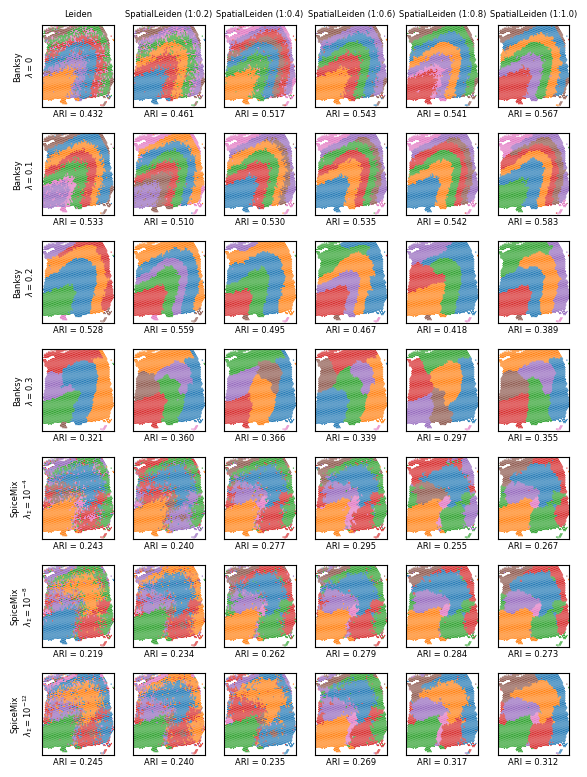

In [42]:
aspect = 0.9

ncol = labels["cluster"].cat.categories.size
nrow = labels["method"].cat.categories.size
SFig7, axs = plt.subplots(
    nrow, ncol, figsize=(200 * mm * aspect * (ncol / nrow), 200 * mm)
)

for i, (c, cdf) in enumerate(labels.groupby("cluster", observed=True)):
    for j, (m, mdf) in enumerate(cdf.groupby("method", observed=True)):
        scatter_labels(mdf.join(coord), "label", axs[j, i])
        axs[j, i].set_xlabel(f"ARI = {ari.at[m, c]:.3f}", labelpad=-5)
        if j == 0:
            axs[j, i].set(title=c)
        else:
            axs[j, i].set(title=None)
        if i == 0:
            axs[j, i].set_ylabel(m, labelpad=-2)
SFig7.tight_layout(h_pad=1, w_pad=0.2)
SFig7.savefig(fig_dir / "FigS7.png", dpi=dpi)